In [1]:
!pip install torchmetrics
!pip install torch-summary

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
import matplotlib.pyplot as plt
from torchsummary import summary

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from typing import List, Any, Union, Tuple
from torch import Tensor
import torch
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchmetrics


def make_sequence_from_time_series(ts: Any, train_seq_size: int, test_seq_size: int) \
        -> Union[Tuple[List, List], Tuple[Tensor, Tensor]]:

    x, y = [], []
    
    if ts.shape[0] - train_seq_size - test_seq_size != 0:
        for i in range(ts.shape[0] - train_seq_size - test_seq_size):
            x_i = ts[i: i + train_seq_size]
            y_i = ts[i + train_seq_size: i + train_seq_size + test_seq_size]
            x.append(x_i)
            y.append(y_i)
    else:
        x = ts[:train_seq_size]
        y = ts[train_seq_size:]
    return x, y


def train_test_split(x_seq: List, y_seq: List, train_size: float) -> tuple[Tensor, Tensor, Tensor, Tensor]:
    return torch.stack(x_seq[: round(len(x_seq) * train_size)]), torch.stack(y_seq[: round(len(x_seq) * train_size)]), \
           torch.stack(x_seq[round(len(x_seq) * train_size):]), torch.stack(y_seq[round(len(x_seq) * train_size):])


def data_scaling(ts: Union[pd.DataFrame, pd.Series]) -> Union[pd.DataFrame, pd.Series]:
    return (ts - ts.mean())/ts.std()


def check_stationarity(ts, cfg='full'):
    
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    
    if cfg == 'full':
        print('ADF Statistic: %f' % dftest[0])
        print('p-value: %f' % dftest[1])
        print('Critical Values:')
    
    for key, value in dftest[4].items():
        if cfg == 'full':
            print('\t%s: %.3f' % (key, value))
    if (pvalue < 0.05) and (adf < critical_value):
        print('The TS is stationary')
    else:
        print('The TS is NOT stationary')
        


def make_diff_n_degree(target, n):
    diff_ts = target

    for i in range(n):
        diff_ts = diff_ts.diff(periods=1).dropna()

    return diff_ts


def show_forecast_test_plot(time, train, forecasts, test):
    fig = go.Figure([go.Scatter(x=time[:len(train)], y=train),
                     go.Scatter(x=time[len(train):], y=forecasts, name='forecast'),
                     go.Scatter(x=time[len(train):], y=test, name='test')])
    fig.show()


def train_lstm(n_epochs, model, loss_fn, optimizer, train_loader, val_loader, device):
    train_losses = []
    val_losses = []
    metric_score = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        train_losses_per_epoch = []
        for X_batch, y_real in train_loader:
            optimizer.zero_grad()

            forecasts = model(X_batch.to(device).float())

            loss = loss_fn(forecasts, y_real.to(device))
            loss.backward()
            optimizer.step()

            train_losses_per_epoch.append(loss.item())
        train_losses.append(np.mean(train_losses_per_epoch))
        
        model.eval()
        val_losses_per_epoch = []
        metric_score_per_epoch = []
        with torch.no_grad():
            for X_batch_val, y_real_val in val_loader:
                y_pred_val = model(X_batch_val.to(device).float())
                loss = loss_fn(y_pred_val, y_real_val.to(device).float())
                score = torchmetrics.functional.mean_absolute_percentage_error(y_pred_val, y_real_val.to(device).float())
                metric_score_per_epoch.append(score.cpu().detach().numpy())
                val_losses_per_epoch.append(loss.item())
                
        metric_score.append(np.mean(metric_score_per_epoch))
        val_losses.append(np.mean(val_losses_per_epoch))

    return train_losses, val_losses, metric_score

def show_loss_after_train(train_loss, val_loss, metric_score):

    plt.figure(figsize=(15, 9))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.subplot(1, 2, 2)
    plt.plot(metric_score)
    plt.xlabel("epochs")
    plt.ylabel("score")
    
    plt.show()

## Обработка временного ряда

In [4]:
# Достаем ряд
df = pd.read_csv('/kaggle/input/tttttt/train.csv')
target = df.target_value

In [5]:
# Выбираем константы для длины входной последовательности и для длины предсказания
seq_len = 14
predict_horizon = 7

### Масштабирование данных и стабилизация дисперсии

In [6]:
# масштабирование
print('Std: ', target.std(), 'Mean: ', target.mean())
target_scaled = data_scaling(target)
print('Std: ', round(target_scaled.std()), 'Mean: ', round(target_scaled.mean()))

Std:  836.4328884415709 Mean:  2078.0138920969944
Std:  1 Mean:  0


Lambda value used for Transformation: -0.43668043973665444
ADF Statistic: -1.551629
p-value: 0.507835
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
The TS is NOT stationary


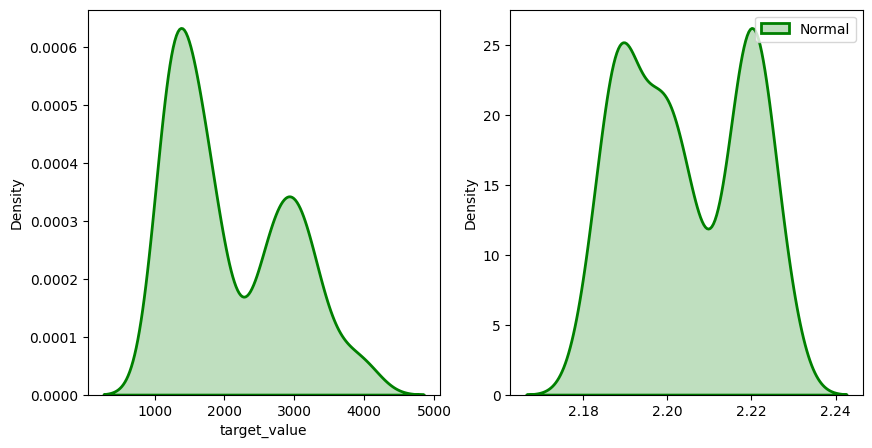

In [7]:
# Стабилизация дисперсии ни к чему не привела
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

fitted_data, fitted_lambda = stats.boxcox(target)
fig, ax = plt.subplots(1, 2)

sns.distplot(target, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])

sns.distplot(fitted_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1])

plt.legend(loc = "upper right")
fig.set_figheight(5)
fig.set_figwidth(10)

print(f"Lambda value used for Transformation: {fitted_lambda}")
check_stationarity(fitted_data)

### Создание последовательностей

### размер выбирается по формуле описанной в этой статье https://arxiv.org/abs/1710.03222

![](sequence.png)
![](train_test_split.png)
![](train_val.png)

In [8]:
# разбиваем на трейн и тест ряд
train_data = torch.tensor(target.iloc[: target.shape[0] - seq_len - predict_horizon].values).float()
test_data = torch.tensor(target.iloc[target.shape[0] - seq_len - predict_horizon: ].values).float()

# создаем из этих рядов последовательности
list_x_train, list_y_train = make_sequence_from_time_series(train_data, seq_len, predict_horizon)
x_train, y_train = torch.stack(list_x_train), torch.stack(list_y_train)

# создаем валидационные выборки
x_val = torch.cat((x_train[:, -(seq_len - predict_horizon):], y_train), dim=1)[:-1]
y_val = y_train[1:]

x_test, y_test = make_sequence_from_time_series(test_data, seq_len, predict_horizon)
x_test, y_test = x_test.unsqueeze(dim=0), y_test.unsqueeze(dim=0)

# # разбиваем последовательность обучения на две части, обучение и валидация
# x_train, y_train, x_val, y_val = train_test_split(list_of_train_x_seq, list_of_train_y_seq, train_size=0.8)

# создаем из этого датасеты
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

# запихиваем все это в даталоадеры
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=15)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=15)

# Создадим ЛСТМ нейронку

In [9]:
class SWISH(nn.Module):
    def __init__(self):
        super(SWISH, self).__init__()
        self.sigmoid = nn.Sigmoid()
    def forward(self, time_series, beta=1):
        return time_series * self.sigmoid(beta * time_series)


    
class OwnLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, seq_len, num_layers):
        super(OwnLSTM, self).__init__()
        self.seq_len = seq_len
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers)
        self.fully_con = nn.Sequential(
            nn.Linear(in_features=hidden_dim * self.seq_len, out_features=320),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=320, out_features=160),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=160, out_features=80),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=80, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=output_dim),
        )

    def forward(self, time_series): 
        lstm_out, _ = self.lstm(torch.unsqueeze(time_series, dim=-1).float())
        y_pred = self.fully_con(lstm_out.reshape(lstm_out.shape[0], lstm_out.shape[1] * lstm_out.shape[2]))            
        return y_pred
    
class OwnLSTM_2(OwnLSTM):
    def __init__(self, input_dim, hidden_dim, output_dim, seq_len, num_layers):
        super(OwnLSTM_2, self).__init__(input_dim, hidden_dim, output_dim, seq_len, num_layers)
        self.fully_con = nn.Sequential(
            nn.Linear(in_features=hidden_dim * self.seq_len, out_features=320),
            SWISH(),
            nn.Dropout(),
            nn.Linear(in_features=320, out_features=160),
            SWISH(),
            nn.Dropout(),
            nn.Linear(in_features=160, out_features=80),
            SWISH(),
            nn.Dropout(),
            nn.Linear(in_features=80, out_features=10),
            SWISH(),
            nn.Linear(in_features=10, out_features=output_dim),
        )

class OwnLSTM_3(OwnLSTM):
    def __init__(self, input_dim, hidden_dim, output_dim, seq_len, num_layers):
        super(OwnLSTM_3, self).__init__(input_dim, hidden_dim, output_dim, seq_len, num_layers)
        self.fully_con = nn.Sequential(
            nn.Linear(in_features=hidden_dim * self.seq_len, out_features=200),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=200, out_features=50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=50, out_features=10),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=10, out_features=output_dim)
        )
        
class OwnLSTM_4(OwnLSTM):
    def __init__(self, input_dim, hidden_dim, output_dim, seq_len, num_layers):
        super(OwnLSTM_4, self).__init__(input_dim, hidden_dim, output_dim, seq_len, num_layers)
        self.fully_con = nn.Sequential(
            nn.Linear(in_features=hidden_dim * self.seq_len, out_features=output_dim)
        )

In [10]:
input_dim = 1 # BASE
hidden_dim = 32 # THE BEST
output_dim = 7 # NEED
num_layers = 10 # THE BEST 

In [11]:
# !pip install torch-summary

In [44]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = OwnLSTM(input_dim, hidden_dim, output_dim, seq_len, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 600
print('TRAINING DEVICE', device)
summary(model)

TRAINING DEVICE cuda:0
Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              80,512
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       143,680
|    └─ReLU: 2-2                         --
|    └─Dropout: 2-3                      --
|    └─Linear: 2-4                       51,360
|    └─ReLU: 2-5                         --
|    └─Dropout: 2-6                      --
|    └─Linear: 2-7                       12,880
|    └─ReLU: 2-8                         --
|    └─Dropout: 2-9                      --
|    └─Linear: 2-10                      810
|    └─ReLU: 2-11                        --
|    └─Linear: 2-12                      77
Total params: 289,319
Trainable params: 289,319
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              80,512
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       143,680
|    └─ReLU: 2-2                         --
|    └─Dropout: 2-3                      --
|    └─Linear: 2-4                       51,360
|    └─ReLU: 2-5                         --
|    └─Dropout: 2-6                      --
|    └─Linear: 2-7                       12,880
|    └─ReLU: 2-8                         --
|    └─Dropout: 2-9                      --
|    └─Linear: 2-10                      810
|    └─ReLU: 2-11                        --
|    └─Linear: 2-12                      77
Total params: 289,319
Trainable params: 289,319
Non-trainable params: 0

In [45]:
train_loss, val_losses, metric_score = train_lstm(num_epochs, model, criterion, optimizer, train_loader, val_loader, device)

  0%|          | 0/600 [00:00<?, ?it/s]

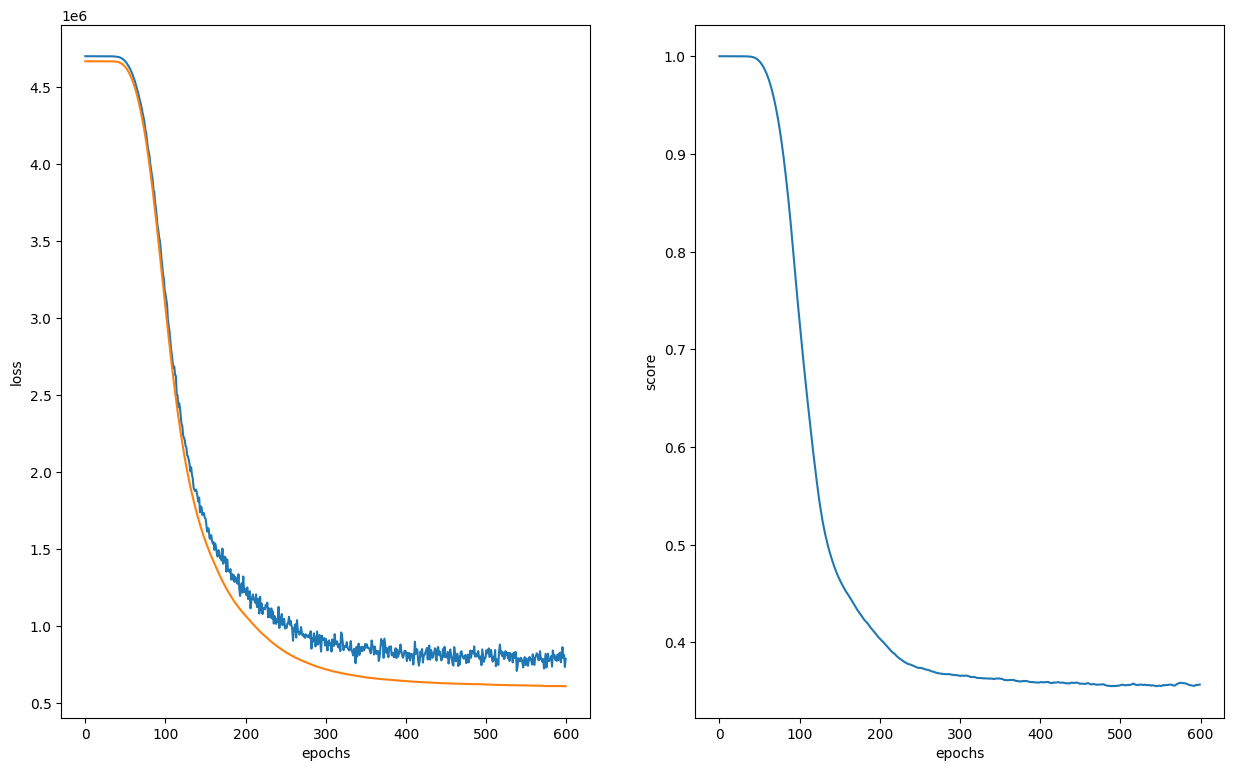

In [46]:
show_loss_after_train(train_loss, val_losses, metric_score)

In [47]:
model.eval()
y_pred = model(x_test.to(device)).cpu().detach().numpy()[0]
y_real = y_test[0]
time = df.Date
train = torch.tensor(df.target_value.iloc[: target.shape[0] - predict_horizon].values).float().numpy()
score = torchmetrics.functional.mean_absolute_percentage_error(torch.FloatTensor(y_pred), y_real)

In [48]:
print('MSE score: ', round(score.item(), 6))
show_forecast_test_plot(time, train, y_pred, y_real)

MSE score:  0.037686


### OwnLSTM
* 64 hidden dim (NORMAL)
    * 0.5522 0 layers 1000 epochs (TRASH may be underfitted) lr 0.00001 without sheduler
    * 0.4689 0 layers 1500 epochs lr 0.00001 without sheduler
    
    * 0.2308 15 layers 1000 epochs overfitted lr 0.00001 without sheduler
    * 0.1860 15 layers 500-600 epochs - OPTIM (BETTER) lr 0.00001 without sheduler

    * 0.2261 10 layers 1000 epochs lr 0.00001 without sheduler
    * 0.1807 10 layers 500 epochs - OPTIM (BETTER THEN NOTHING) lr 0.00001 without sheduler

    * 0.1991 5 layers 600 epochs - OPTIM (BAD) lr 0.00001 without sheduler
    * 0.2206 5 layers 800 epochs lr 0.00001 without sheduler

* 32 hidden dim (BEST)
    * 0.4282 0 layers 1500 epochs lr 0.00001 without sheduler
    * 0.5165 0 layers 2000 epochs lr 0.00001 without sheduler

    * 0.1017 10 layers 1000 epochs lr 0.00001 without sheduler
    * 0.0284 10 layers 600 epochs (BEST OF THE BEST) lr 0.00001 without sheduler

* 16 hidden dim (BAD)
    * 0.0866 10 layers 1000 epochs lr 0.00001 without sheduler
    * 0.2375 10 layers 750 epochs lr 0.00001 without sheduler
    
### OwnLSTM_2 (NOT BAD BUT... RELU BETTER)
* 32 hidden dim 
    *  0.0698 10 layers 1000 epochs lr 0.00001 without sheduler
    *  0.2764 10 layers 600 epochs lr 0.00001 without sheduler
    
### OwnLSTM_3 
* 32 hidden dim
    * 0.0922 10 layers 1000 epochs lr 0.00001 without sheduler
    * 0.0435 10 layers 1500 epochs lr 0.00001 without sheduler
    
### OwnLSTM_4 (TRASH)
* 32 hidden dim
    * 0.919761 10 layers 1500 epochs (underfitted) lr 0.00001 without sheduler

In [ ]:
# _____ GRID SEARCH  ____
# def grid_search_of_hyperparameters(hid_dim: list, seq: list, num_layers: list, epochs: list):
#     all_metrics = []
#     all_info = []
#     for dim in hid_dim:
#         for sequence in seq:
#             for layers in num_layers:
#                 for epoch in epochs:  
#                     model = OwnLSTM(input_dim, dim, output_dim, sequence, layers).to(device)
#                     criterion = nn.MSELoss()
#                     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#                     num_epochs = epoch
#                     _, _, metric_score = train_lstm(num_epochs, model, criterion, optimizer, train_loader, val_loader, device)
                    
#                     model.eval()
#                     y_pred = model(x_test.to(device)).cpu().detach().numpy()[0]
#                     y_real = y_test[0]
#                     time = df.Date
#                     train = torch.tensor(df.target_value.iloc[: target.shape[0] - predict_horizon].values).float().numpy()
#                     score = torchmetrics.functional.mean_absolute_percentage_error(torch.FloatTensor(y_pred), y_real)
#                     all_info.append(f"Score {score.item()}, Num Epochs: {epoch}, Num Layers: {layers}, Sequence Length: {sequence}, Hidden Dimention: {dim}")
#                     all_metrics.append(score.item())
                    
#     return all_metrics, all_info

# hidden_dimention = [16, 32, 64, 92, 128]
# length_of_sequence = [7, 10, 14, 17, 20]
# num_of_layers_in_model = [0, 2, 5, 10, 15]
# num_of_epochs_train = [600, 1000, 1200, 1500]


# all_metrics, all_info = grid_search_of_hyperparameters(hidden_dimention, length_of_sequence, num_of_layers_in_model, num_of_epochs_train)

In [ ]:
#TODO : SCALING TRANSFORM, SOME OTHERS LSTM MODELS, MAYBE ADD CONV

In [ ]:
def data_unscaling(target, mean_target, std_target):
    return target*std_target + mean_target

### Data Normalization

In [11]:
from pandas import DataFrame

class MiniMaxScaler:
    def __init__(self, feature_range=(0, 1)):
        self.feature_range = feature_range
        self.min_value = None
        self.max_value = None
    
    def fit(self, time_series):
        self.min_value = time_series.min()
        self.max_value = time_series.max()
    
    def transform(self, time_series):
        return (time_series - self.min_value) / (self.max_value - self.min_value) * (self.feature_range[1] - self.feature_range[0]) + self.feature_range[0]
    
    def inverse_transform(self, time_series):
        return (time_series - self.feature_range[0]) / (self.feature_range[1] - self.feature_range[0]) * (self.max_value - self.min_value) + self.min_value
    
    def fit_transform(self, time_series):
        self.fit(time_series)
        return self.transform(time_series)     

In [140]:
# Достаем ряд
df = pd.read_csv('/kaggle/input/tttttt/train.csv')
target = df.target_value

# Выбираем константы для длины входной последовательности и для длины предсказания
seq_len = 14
predict_horizon = 7

In [141]:
# применяем MiniMaxScaler ко всему ряду
scaler = MiniMaxScaler()
scaled_target = scaler.fit_transform(target)
print(f"Data Minimum: {scaler.min_value} \nData Maximum: {scaler.max_value}")

# разбиваем на трейн и тест ряд
train_data = torch.tensor(scaled_target.iloc[: scaled_target.shape[0] - seq_len - predict_horizon].values).float()
test_data = torch.tensor(scaled_target.iloc[scaled_target.shape[0] - seq_len - predict_horizon: ].values).float()

# создаем из этих рядов последовательности
list_x_train, list_y_train = make_sequence_from_time_series(train_data, seq_len, predict_horizon)
x_train, y_train = torch.stack(list_x_train), torch.stack(list_y_train)

# создаем валидационные выборки
x_val = torch.cat((x_train[:, -(seq_len - predict_horizon):], y_train), dim=1)[:-1]
y_val = y_train[1:]

x_test, y_test = make_sequence_from_time_series(test_data, seq_len, predict_horizon)
x_test, y_test = x_test.unsqueeze(dim=0), y_test.unsqueeze(dim=0)

# # разбиваем последовательность обучения на две части, обучение и валидация
# x_train, y_train, x_val, y_val = train_test_split(list_of_train_x_seq, list_of_train_y_seq, train_size=0.8)

# создаем из этого датасеты
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

# запихиваем все это в даталоадеры
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=15)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=15)

Data Minimum: 1040.0073550000002 
Data Maximum: 4080.739868
torch.Size([345])


In [86]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = OwnLSTM(input_dim, hidden_dim, output_dim, seq_len, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 480
print('TRAINING DEVICE', device)
summary(model)

TRAINING DEVICE cuda:0
Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              80,512
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       143,680
|    └─ReLU: 2-2                         --
|    └─Dropout: 2-3                      --
|    └─Linear: 2-4                       51,360
|    └─ReLU: 2-5                         --
|    └─Dropout: 2-6                      --
|    └─Linear: 2-7                       12,880
|    └─ReLU: 2-8                         --
|    └─Dropout: 2-9                      --
|    └─Linear: 2-10                      810
|    └─ReLU: 2-11                        --
|    └─Linear: 2-12                      77
Total params: 289,319
Trainable params: 289,319
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              80,512
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       143,680
|    └─ReLU: 2-2                         --
|    └─Dropout: 2-3                      --
|    └─Linear: 2-4                       51,360
|    └─ReLU: 2-5                         --
|    └─Dropout: 2-6                      --
|    └─Linear: 2-7                       12,880
|    └─ReLU: 2-8                         --
|    └─Dropout: 2-9                      --
|    └─Linear: 2-10                      810
|    └─ReLU: 2-11                        --
|    └─Linear: 2-12                      77
Total params: 289,319
Trainable params: 289,319
Non-trainable params: 0

In [87]:
train_loss, val_losses, metric_score = train_lstm(num_epochs, model, criterion, optimizer,train_loader, val_loader, device)

  0%|          | 0/480 [00:00<?, ?it/s]

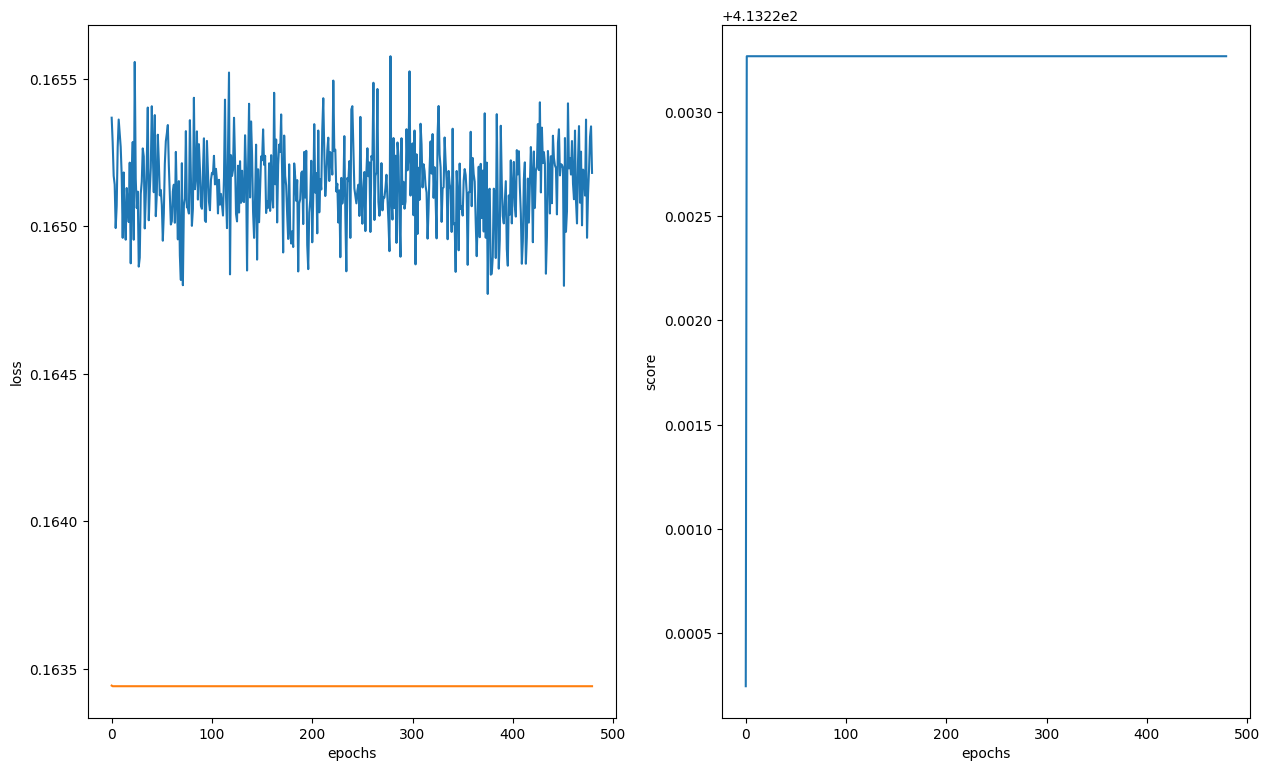

In [88]:
show_loss_after_train(train_loss, val_losses, metric_score)

In [89]:
# тоже как раньше но еще делаем обратное преобразование нормализации чтобы вернуть значения в исходное распредление
model.eval()
y_pred = scaler.inverse_transform(model(x_test.to(device)).cpu().detach().numpy()[0])
y_real = scaler.inverse_transform(y_test[0]) 
time = df.Date
train = torch.tensor(df.target_value.iloc[: target.shape[0] - predict_horizon].values).float().numpy()
score = torchmetrics.functional.mean_absolute_percentage_error(torch.FloatTensor(y_pred), y_real)

In [90]:
#0.1938 10 num layers 480 epoch 0.0001 lr no sheduler 
print('MSE score: ', round(score.item(), 6))
show_forecast_test_plot(time, train, y_pred, y_real)

MSE score:  0.334482


### Make Stationary 

In [12]:
class DifferencingTransformer:
    def __init__(self):
        self.initial_value = None

    def fit(self, series):
        self.initial_value = series[0]

    def fit_transform(self, series: DataFrame) -> DataFrame:
        self.fit(series)
        differenced_series = []
        previous_value = self.initial_value

        for value in series:
            difference = value - previous_value
            differenced_series.append(difference)
            previous_value = value

        return DataFrame(differenced_series).iloc[:, 0]

    def inverse_transform(self, differenced_series: Tensor) -> Tensor:
        series = []
        previous_value = self.initial_value

        for difference in differenced_series:
            value = previous_value + difference
            series.append(value)
            previous_value = value

        return series
    
    
    
def make_sequence_from_time_series_differenced(ts: Any, train_seq_size: int, test_seq_size: int) \
        -> Union[Tuple[List, List], Tuple[Tensor, Tensor]]:

    x, y = [], []
    
    if ts.shape[0] - train_seq_size - test_seq_size != 0:
        for i in range(ts.shape[0] - train_seq_size - test_seq_size):
            transformer_x_i = DifferencingTransformer()
            transformer_y_i = DifferencingTransformer()
            x_i = ts[i: i + train_seq_size]
            x_i = torch.Tensor(transformer_x_i.fit_transform(x_i))
            y_i = ts[i + train_seq_size: i + train_seq_size + test_seq_size]
            y_i = torch.Tensor(transformer_y_i.fit_transform(y_i))
            x.append(x_i)
            y.append(y_i)
    else:
        transformer_x = DifferencingTransformer()
        transformer_y = DifferencingTransformer()

        x = torch.Tensor(transformer_x.fit_transform(ts[:train_seq_size]))
        y = torch.Tensor(transformer_y.fit_transform(ts[train_seq_size:]))
    return x, y

In [67]:
# Достаем ряд
df = pd.read_csv('/kaggle/input/tttttt/train.csv')
target = df.target_value

# Выбираем константы для длины входной последовательности и для длины предсказания
seq_len = 14
predict_horizon = 7

In [68]:
# # ДатаФрейм трейновой части
# train_x_y = target.iloc[: target.shape[0] - seq_len - predict_horizon].values

# # ДатаФрейм тестовой части
# test_x_y = target.iloc[target.shape[0] - seq_len - predict_horizon:].values

# # Разбиение прошлого датафрейма на Х и У 
# test_x_series = test_x_y[:seq_len]
# test_y_series = pd.Series(test_x_y[seq_len:])

# # Инициализируем Дифференциаторы для трейна свой и для теста тоже свой
# transformer_test = DifferencingTransformer()

# # Дифференцируем трейн и Х часть теста
# transformed_target_test = transformer_test.fit_transform(test_x_series)


# # check_stationarity(transformed_target, cfg='partial')


# # разбиваем на трейн и тест ряд
# train_data = torch.tensor(train_x_y).float()
# test_data = torch.tensor(transformed_target_test.values).float()

# # создаем из этих рядов последовательности
# list_x_train, list_y_train = make_sequence_from_time_series_differenced(train_data, seq_len, predict_horizon)
# x_train, y_train = torch.stack(list_x_train), torch.stack(list_y_train)

# # создаем валидационные выборки
# x_val = torch.cat((x_train[:, -(seq_len - predict_horizon):], y_train), dim=1)[:-1]
# y_val = y_train[1:]

# x_test, y_test = torch.Tensor(transformed_target_test), torch.Tensor(test_y_series)
# x_test, y_test = x_test.unsqueeze(dim=0), y_test.unsqueeze(dim=0)

# # # разбиваем последовательность обучения на две части, обучение и валидация
# # x_train, y_train, x_val, y_val = train_test_split(list_of_train_x_seq, list_of_train_y_seq, train_size=0.8)

# # создаем из этого датасеты
# train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
# val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

# # запихиваем все это в даталоадеры
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=15)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=15)


In [69]:
# ДатаФрейм трейновой части
train_x_y = target.iloc[: target.shape[0] - seq_len - predict_horizon].values

# ДатаФрейм тестовой части
test_x_y = target.iloc[target.shape[0] - seq_len - predict_horizon:].values

# Разбиение прошлого датафрейма на Х и У 
test_x_series = test_x_y[:seq_len]
test_y_series = pd.Series(test_x_y[seq_len:])

# Инициализируем Дифференциаторы для трейна свой и для теста тоже свой
transformer_train = DifferencingTransformer()
transformer_test = DifferencingTransformer()

# Дифференцируем трейн и Х часть теста
transformed_target_train = transformer_train.fit_transform(train_x_y)
transformed_target_test = transformer_test.fit_transform(test_x_series)


# check_stationarity(transformed_target, cfg='partial')


# разбиваем на трейн и тест ряд
train_data = torch.tensor(transformed_target_train.values).float()
test_data = torch.tensor(transformed_target_test.values).float()

# создаем из этих рядов последовательности
list_x_train, list_y_train = make_sequence_from_time_series(train_data, seq_len, predict_horizon)
x_train, y_train = torch.stack(list_x_train), torch.stack(list_y_train)

# создаем валидационные выборки
x_val = torch.cat((x_train[:, -(seq_len - predict_horizon):], y_train), dim=1)[:-1]
y_val = y_train[1:]

x_test, y_test = torch.Tensor(transformed_target_test), torch.Tensor(test_y_series)
x_test, y_test = x_test.unsqueeze(dim=0), y_test.unsqueeze(dim=0)

# # разбиваем последовательность обучения на две части, обучение и валидация
# x_train, y_train, x_val, y_val = train_test_split(list_of_train_x_seq, list_of_train_y_seq, train_size=0.8)

# создаем из этого датасеты
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

# запихиваем все это в даталоадеры
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=15)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=15)


In [70]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = OwnLSTM(input_dim, hidden_dim, output_dim, seq_len, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
num_epochs = 1300
print('TRAINING DEVICE', device)
summary(model)

TRAINING DEVICE cuda:0
Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              80,512
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       143,680
|    └─ReLU: 2-2                         --
|    └─Dropout: 2-3                      --
|    └─Linear: 2-4                       51,360
|    └─ReLU: 2-5                         --
|    └─Dropout: 2-6                      --
|    └─Linear: 2-7                       12,880
|    └─ReLU: 2-8                         --
|    └─Dropout: 2-9                      --
|    └─Linear: 2-10                      810
|    └─ReLU: 2-11                        --
|    └─Linear: 2-12                      77
Total params: 289,319
Trainable params: 289,319
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              80,512
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       143,680
|    └─ReLU: 2-2                         --
|    └─Dropout: 2-3                      --
|    └─Linear: 2-4                       51,360
|    └─ReLU: 2-5                         --
|    └─Dropout: 2-6                      --
|    └─Linear: 2-7                       12,880
|    └─ReLU: 2-8                         --
|    └─Dropout: 2-9                      --
|    └─Linear: 2-10                      810
|    └─ReLU: 2-11                        --
|    └─Linear: 2-12                      77
Total params: 289,319
Trainable params: 289,319
Non-trainable params: 0

In [71]:
train_loss, val_losses, metric_score = train_lstm(num_epochs, model, criterion, optimizer,train_loader, val_loader, device)

  0%|          | 0/1300 [00:00<?, ?it/s]

1282
1005


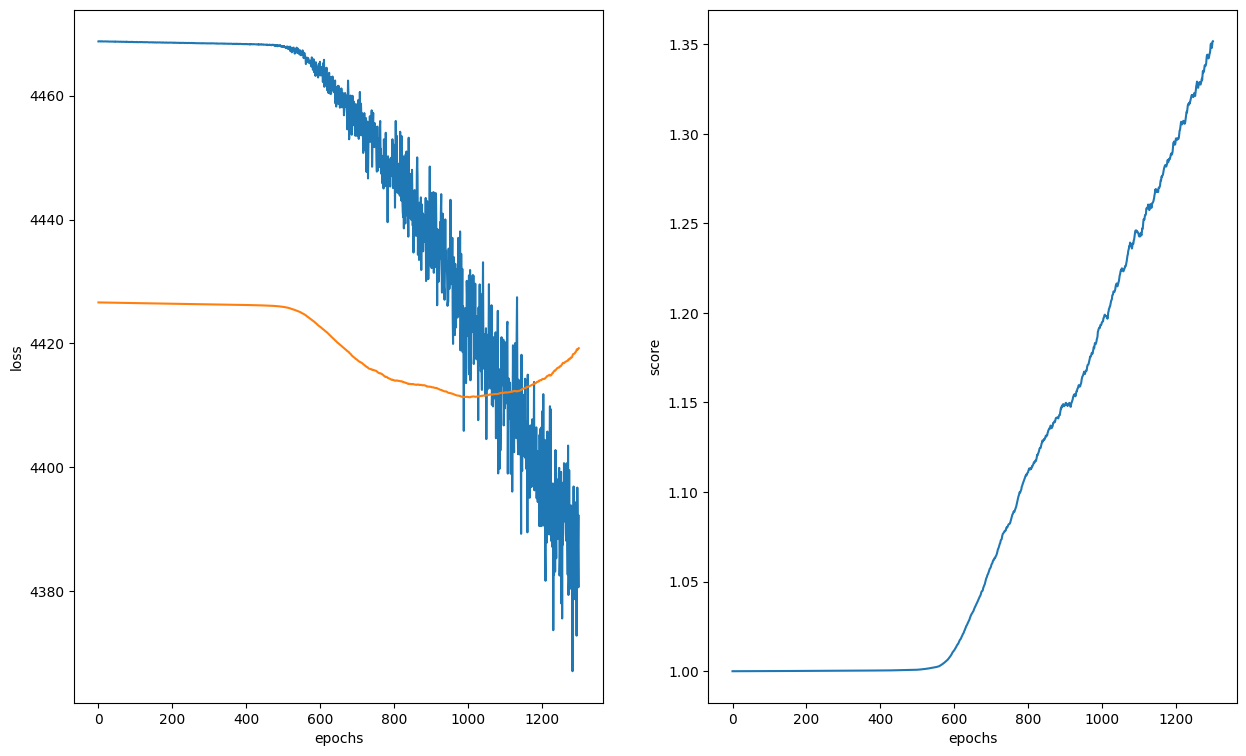

In [72]:
print(np.argmin(np.array(train_loss)))
print(np.argmin(np.array(val_losses)))
show_loss_after_train(train_loss, val_losses, metric_score)

In [73]:
# тоже как раньше но еще делаем обратное преобразование нормализации чтобы вернуть значения в исходное распредление
model.eval()
y_pred = transformer_test.inverse_transform(model(x_test.to(device)).cpu().detach().numpy()[0])
# y_real = transformer.inverse_transform(y_test[0])
# y_pred = model(x_test.to(device)).cpu().detach().numpy()[0]
y_real = y_test[0]
time = df.Date
train = torch.tensor(df.target_value.iloc[: target.shape[0] - predict_horizon].values).float().numpy()
score = torchmetrics.functional.mean_absolute_percentage_error(torch.FloatTensor(y_pred), y_real)

In [74]:
#0.0322 700 epochs 10 num layers 0.001 lr diff
#0.0463 1200 epochs 10 num layers 0.001 lr diff
#0.0223 250 epochs 10 num layers 0.01 lr diff
#0.0182 800 epochs 10 num layers 0.01 lr diff
print('MSE score: ', round(score.item(), 6))
show_forecast_test_plot(time, train, y_pred, y_real)

MSE score:  0.049743


### Both (Stationary + Normalize)